In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import yfinance

from rfcorr.random_forest import get_corr, get_pairwise_corr

In [2]:
rs = numpy.random.RandomState(42)

In [3]:
# fetch all symbols
symbol_list = ["SPY",
              "XLB",
              "XLE",
              "XLF",
               "XLI",
               "XLK",
               "XLP",
               "XLU",
               "XLV",
               "XLRE",
              ]

symbol_df = yfinance.download(symbol_list, progress=False)
symbol_df = symbol_df.dropna(axis=0)
print(symbol_df.shape)

(1604, 60)


In [4]:
close_close_ret_df = numpy.log(symbol_df.loc[:, "Adj Close"]).diff().iloc[1:]
close_close_ret_df.tail()

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV
Date,,,,,,,,,,
2022-02-14,-0.003275,-0.008248,-0.023859,-0.011283,-0.003731,-0.000323,-0.002795,-0.010847,-0.008540,-0.010264
2022-02-15,0.015998,0.018199,-0.010528,0.013524,0.014940,0.025946,0.001731,0.004885,-0.004675,0.011184
2022-02-16,0.001120,0.007281,0.008052,0.000746,0.005261,-0.001007,0.001861,0.002654,0.002265,0.001533
2022-02-17,-0.021593,-0.017232,-0.001605,-0.025171,-0.018485,-0.030378,0.007672,-0.008652,0.000603,-0.016214
2022-02-18,-0.006496,-0.001668,-0.006153,-0.000255,-0.008304,-0.010182,0.001843,-0.004466,-0.001810,-0.007501


In [9]:
window = 20
start_date = pandas.Timestamp(datetime.date(2021, 9, 1))
start_date_index = [i for i, ix in enumerate(close_close_ret_df.index)
                    if ix >= start_date]
if len(start_date_index) > 0:
    start_date_index = start_date_index[0]
    if start_date_index <= window:
        raise ValueError("start_date and window are not compatible")
else:
    raise ValueError("start_date and data are not compatible")

window_corr_ts_list = []
window_corr_ts_index = []

for window_df in close_close_ret_df.iloc[(start_date_index - window):].rolling(window=window):
    if window_df.shape[0] == window:
        window_corr_ts_list.append(pandas.DataFrame(get_pairwise_corr(window_df.values,
                                                         num_trees=100,
                                                         lag=0, 
                                                         method="regression",
                                                         random_state=rs),
                                                columns=close_close_ret_df.columns,
                                                index=close_close_ret_df.columns))
        window_corr_ts_index.append(window_df.index[-1])

window_corr_ts_array = numpy.stack(window_corr_ts_list)
print(window_corr_ts_array.shape)

(120, 10, 10)


<AxesSubplot:title={'center':'Sector - SPY "rfcorr" time series (method=regression, window=20, lag=1)'}, xlabel='Date', ylabel='Correlation'>

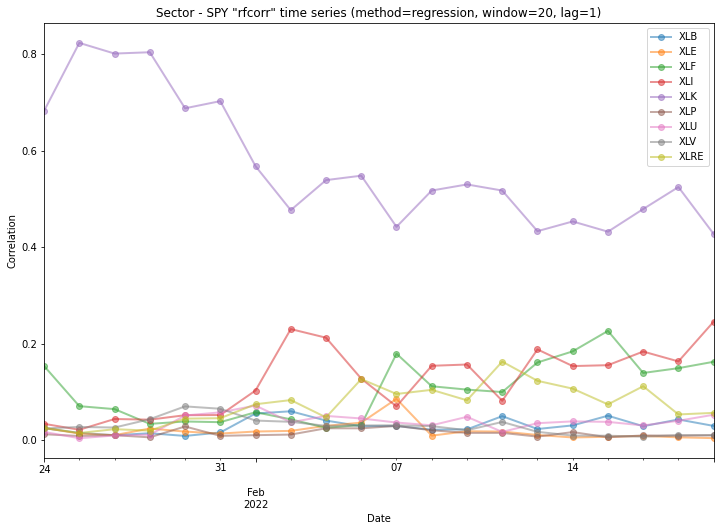

In [10]:
spy_index = symbol_list.index("SPY")
spy_corr_ts = pandas.DataFrame(window_corr_ts_array[:, spy_index, :], 
                 columns=symbol_list,
                 index=window_corr_ts_index)\
    .drop("SPY", axis=1)

f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("Sector - SPY \"rfcorr\" time series (method=regression, window=20, lag=0)")
ax.set_ylabel("Correlation")
ax.set_xlabel("Date")
spy_corr_ts.tail(20).plot(ax=ax, linewidth=2, alpha=0.5, marker="o")

<AxesSubplot:title={'center':'SPY - Sector "rfcorr" time series (method=regression, window=20, lag=1)'}, xlabel='Date', ylabel='Correlation'>

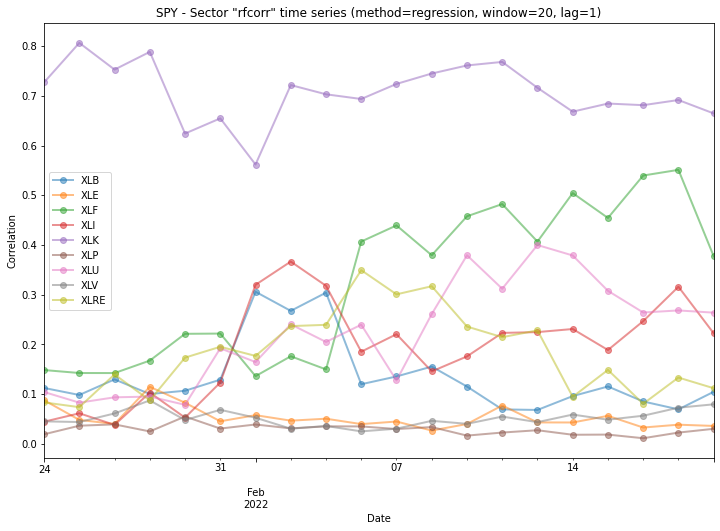

In [11]:
spy_index = symbol_list.index("SPY")
spy_corr_ts = pandas.DataFrame(window_corr_ts_array[:, :, spy_index], 
                 columns=symbol_list,
                 index=window_corr_ts_index)\
    .drop("SPY", axis=1)

f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("SPY - Sector \"rfcorr\" time series (method=regression, window=20, lag=0)")
ax.set_ylabel("Correlation")
ax.set_xlabel("Date")
spy_corr_ts.tail(20).plot(ax=ax, linewidth=2, alpha=0.5, marker="o")

In [12]:
window = 20
start_date = pandas.Timestamp(datetime.date(2021, 9, 1))
start_date_index = [i for i, ix in enumerate(close_close_ret_df.index)
                    if ix >= start_date]
if len(start_date_index) > 0:
    start_date_index = start_date_index[0]
    if start_date_index <= window:
        raise ValueError("start_date and window are not compatible")
else:
    raise ValueError("start_date and data are not compatible")

window_corr_ts_list = []
window_corr_ts_index = []

for window_df in close_close_ret_df.iloc[(start_date_index - window):].rolling(window=window):
    if window_df.shape[0] == window:
        window_corr_ts_list.append(pandas.DataFrame(get_pairwise_corr(window_df.values,
                                                         num_trees=100,
                                                         lag=1, 
                                                         method="regression",
                                                         random_state=rs),
                                                columns=close_close_ret_df.columns,
                                                index=close_close_ret_df.columns))
        window_corr_ts_index.append(window_df.index[-1])

window_corr_ts_array = numpy.stack(window_corr_ts_list)
print(window_corr_ts_array.shape)

(120, 10, 10)


<AxesSubplot:title={'center':'Sector - SPY "rfcorr" time series (method=regression, window=20, lag=1)'}, xlabel='Date', ylabel='Correlation'>

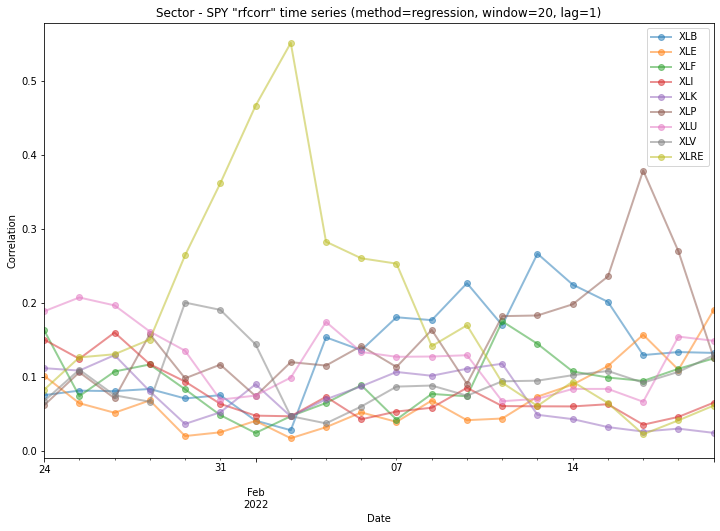

In [14]:
spy_index = symbol_list.index("SPY")
spy_corr_ts = pandas.DataFrame(window_corr_ts_array[:, spy_index, :], 
                 columns=symbol_list,
                 index=window_corr_ts_index)\
    .drop("SPY", axis=1)

f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("Sector - SPY \"rfcorr\" time series (method=regression, window=20, lag=1)")
ax.set_ylabel("Correlation")
ax.set_xlabel("Date")
spy_corr_ts.tail(20).plot(ax=ax, linewidth=2, alpha=0.5, marker="o")

<AxesSubplot:title={'center':'SPY - Sector "rfcorr" time series (method=regression, window=20, lag=1)'}, xlabel='Date', ylabel='Correlation'>

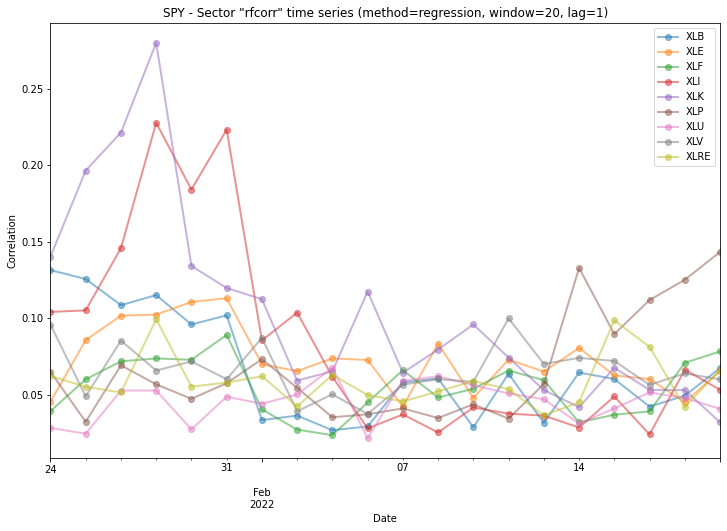

In [15]:
spy_index = symbol_list.index("SPY")
spy_corr_ts = pandas.DataFrame(window_corr_ts_array[:, :, spy_index], 
                 columns=symbol_list,
                 index=window_corr_ts_index)\
    .drop("SPY", axis=1)

f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("SPY - Sector \"rfcorr\" time series (method=regression, window=20, lag=1)")
ax.set_ylabel("Correlation")
ax.set_xlabel("Date")
spy_corr_ts.tail(20).plot(ax=ax, linewidth=2, alpha=0.5, marker="o")